In [ ]:
!pip install catboost
!pip install koreanize-matplotlib

In [ ]:
# 라이브러리 세팅
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
from google.colab import drive
import koreanize_matplotlib
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    silhouette_score,
    davies_bouldin_score
)
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier,plot_importance
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from functools import reduce
import holidays
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objects as go
from scipy.stats import chi2_contingency

# 준비하기

In [ ]:
# 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경로 지정하기
wd = '/content/drive/MyDrive/중급프로젝트2_1팀/data'
os.chdir(wd)

In [ ]:
# 데이터 불러오기
site_area = pd.read_csv('site_area.csv')
trial_access_log = pd.read_csv('trial_access_log.csv')
trial_payment = pd.read_csv('trial_payment.csv')
trial_register = pd.read_csv('trial_register.csv')
trial_visit_info = pd.read_csv('trial_visit_info.csv')
bus_stop_df = pd.read_csv('bus_stop_count_by_branch.csv')
subway_station_df = pd.read_csv('지점별 도시철도역 개수.csv')
store_list_df = pd.read_csv('branch_surrounding_summary.csv')

# EDA

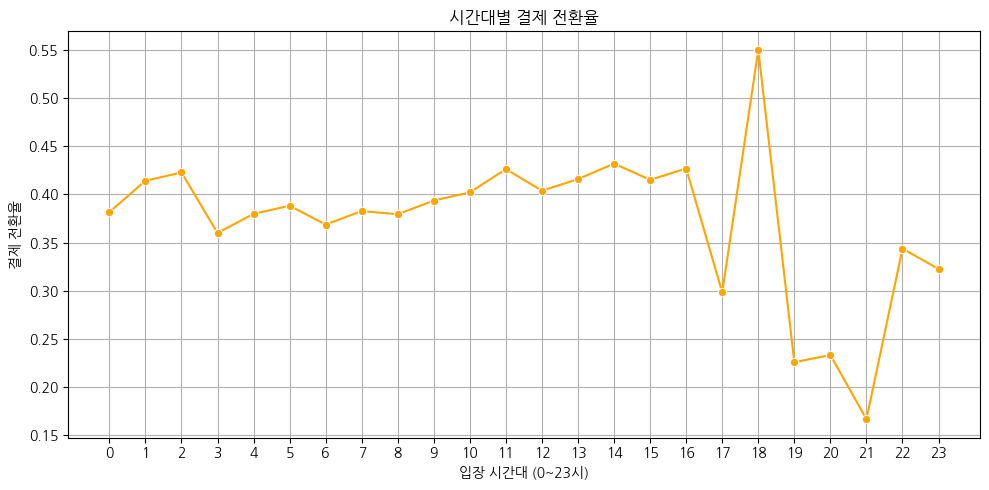

In [ ]:
drop_total_df['check_in_hour'] = pd.to_datetime(drop_total_df['check_in_str'], format='%H:%M:%S').dt.hour


# 시간대별 결제 전환율 계산
conversion_by_hour = drop_total_df.groupby('check_in_hour')['is_payment'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 5))
sns.lineplot(data=conversion_by_hour,
             x='check_in_hour',
             y='is_payment',
             marker='o',
             color='orange')
plt.title('시간대별 결제 전환율')
plt.xlabel('입장 시간대 (0~23시)')
plt.ylabel('결제 전환율')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


### site_area

In [ ]:
site_area

,site_id,area_pyeong
0,1,50
1,2,100
2,3,150
3,4,100
4,5,150
5,6,150
6,17,50
7,47,50
8,49,50


- 50평인 지점이 4개
- 100평인 지점이 2개
- 150평인 지점이 3개

### trial_access_log

In [ ]:
trial_access_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         63708 non-null  int64         
 1   checkin    63708 non-null  int64         
 2   cdate      63708 non-null  datetime64[ns]
 3   site_id    63708 non-null  int64         
 4   user_uuid  63708 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.4+ MB


In [ ]:
trial_access_log.head()

,id,checkin,cdate,site_id,user_uuid
0,1719038,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
1,1716702,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
2,1719956,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
3,1716588,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
4,1719649,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89


In [ ]:
trial_access_log['cdate'] = pd.to_datetime(trial_access_log['cdate'])

In [ ]:
trial_access_log['cdate'].min(), trial_access_log['cdate'].max()

(Timestamp('2021-05-02 09:42:13.893455'),
 Timestamp('2024-01-01 14:36:13.987243'))

In [ ]:
trial_access_log.nunique()

,0
id,63349
checkin,2
cdate,63349
site_id,9
user_uuid,6026


In [ ]:
# trial_access_log 결측값 확인
trial_access_log.isnull().sum()

,0
id,0
checkin,0
cdate,0
site_id,0
user_uuid,0


In [ ]:
trial_access_log['checkin'].value_counts()

,count
checkin,
1,32144
2,31564


체크인의 1과 2의 수가 다름.

### trial_payment

In [ ]:
trial_payment.head()

,is_payment,user_uuid
0,0,2b251333-8676-4c11-a736-dcf2350f8821
1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,1,4a184795-b056-4572-a874-644f68609ea3
3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0


In [ ]:
trial_payment['is_payment'].value_counts()

,count
is_payment,
0,5995
1,3664


결제를 한 사람보다 안한 사람이 훨씬 많다.

In [ ]:
trial_payment.nunique()

,0
is_payment,2
user_uuid,9624


### trial_register

In [ ]:
trial_register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9659 non-null   object
 1   user_uuid   9659 non-null   object
dtypes: object(2)
memory usage: 151.1+ KB


trial_access_log와 user_uuid의 수가 다름 무료 체험을 신청하고 실제로 방문 한 사람과 신청만 하고 안 온 사람이 있다는 것을 알 수 있음

In [ ]:
trial_register['trial_date'] = pd.to_datetime(trial_register['trial_date'])

In [ ]:
trial_register['trial_date'].min(), trial_register['trial_date'].max()

(Timestamp('2021-05-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [ ]:
trial_register['year_month'] = trial_register['trial_date'].dt.to_period('M').astype(str)

# 월별 신규 유저 수 계산
monthly_new_users = (
    trial_register.groupby('year_month')['user_uuid']
    .nunique()
    .reset_index(name='new_users')
)


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_new_users['year_month'],
    y=monthly_new_users['new_users'],
    mode='lines+markers',
    line=dict(width=3),
    marker=dict(size=8),
    name='월별 신규 유저 수',
    hovertemplate='%{x}<br>신규 유저: %{y}<extra></extra>'
))

fig.update_layout(
    title='월별 무료 체험 신규 유저 수 추이',
    xaxis_title='연-월',
    yaxis_title='신규 유저 수',
    xaxis=dict(tickangle=-45, tickfont=dict(size=10)),
    template='plotly_white',
    width=900,
    height=500
)

fig.show()


### trial_visit_info

In [ ]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_id           11477 non-null  int64 
 1   date              11477 non-null  object
 2   stay_time         11477 non-null  object
 3   stay_time_second  11477 non-null  int64 
 4   first_enter_time  10922 non-null  object
 5   last_leave_time   10922 non-null  object
 6   user_uuid         11477 non-null  object
dtypes: int64(2), object(5)
memory usage: 627.8+ KB


first_enter_time과 las_leave_time에 결측치 존제

In [ ]:
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'])

In [ ]:
trial_visit_info.describe(include='all')

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
count,11477.000000,11477,11477,11477.000000,10922,10922,11477
unique,NaN,972,11429,NaN,10599,10599,6534
top,NaN,2022-12-09,08:44:09.950674,NaN,2022-08-10 00:00:00,2023-06-20 23:59:59,039fa563-fc65-4b0c-9087-4beb5cd17fd7
freq,NaN,57,2,NaN,6,6,8
mean,7.502832,NaN,NaN,16689.460922,NaN,NaN,NaN
std,11.608720,NaN,NaN,11968.841154,NaN,NaN,NaN
min,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN
25%,2.000000,NaN,NaN,7776.000000,NaN,NaN,NaN
50%,4.000000,NaN,NaN,14699.000000,NaN,NaN,NaN
75%,6.000000,NaN,NaN,23326.000000,NaN,NaN,NaN


- `first_enter_time` 과 `last_leave_time`에 매칭은 잘 되어 있음 (카운트와 유니크 수 같음)
하지만 똑같은 값 2022년 8월 10일 00시 00분 00초와 2023년 06월 20일 23시 59분 59초라는 값이 6번씩 중복되어 나옴
- `4beb5cd17fd7` 라는 아이디를 가지고 있는 유저가 8번 등장했는데 이 유저의 오류일 가능성
- 체류 시간의 최댓값이 거의 24시간에 가까운 값이 있는데 24시 공유 오피스이긴 하지만 정말로 거의 24시간동안 머무른건지 확인 필요.

## 방문 여부가 결제 여부에 영향을 주는가?

방문한 사람과 방문을 안한 사람들의 결제율의 통계적으로 유의하게 다른지 확인

범주형 변수 (is_visited, is_payment) 사이의 독립성 여부 체크

    H₀ (귀무가설): 방문 여부와 결제 여부는 관련 없다

    H₁ (대립가설): 방문 여부와 결제 여부는 관련 있다 (즉, 방문이 결제에 영향을 미친다)

In [ ]:
register_df = trial_register.copy()

# 방문 여부
visited_users = set(trial_visit_info['user_uuid'].unique())
register_df['is_visited'] = register_df['user_uuid'].isin(visited_users).astype(int)

# 결제 여부 병합
register_df = register_df.merge(trial_payment, on='user_uuid', how='left')
register_df['is_payment'] = register_df['is_payment'].fillna(0).astype(int)

# 교차표
table = pd.crosstab(register_df['is_visited'], register_df['is_payment'])
print("교차표:\n", table)

# 결제율 추가
table['total'] = table.sum(axis=1)
table['결제율'] = (table[1] / table['total']) * 100
print("\n결과 요약:\n", table)


교차표:
 is_payment     0     1
is_visited            
0           2017  1097
1           4024  2591

결과 요약:
 is_payment     0     1  total        결제율
is_visited                              
0           2017  1097   3114  35.228003
1           4024  2591   6615  39.168556


방문 여부와 결제 여부는 통계적으로 유의미한 상관관계가 있다.

# 전처리

## 날짜 변환하기

In [ ]:
# stay_time은 timedelta 처리
trial_visit_info['stay_time'] = pd.to_timedelta(trial_visit_info['stay_time'].astype(str).str.replace('−', '-', regex=False), errors='coerce')
# 시간 정보(HH:MM:SS)만 추출 (소수점 제거)
trial_visit_info['first_enter_time'] = pd.to_datetime(trial_visit_info['first_enter_time'], errors='coerce').dt.strftime('%H:%M:%S')
trial_visit_info['last_leave_time'] = pd.to_datetime(trial_visit_info['last_leave_time'], errors='coerce').dt.strftime('%H:%M:%S')
# stay_time도 보기 좋게 HH:MM:SS로 변환
trial_visit_info['stay_time'] = trial_visit_info['stay_time'].apply(
    lambda x: str(x).split('.')[0] if pd.notnull(x) else None
)

## access 로그 정리 (입장/퇴장 짝 맞추기)

In [ ]:
# `trial_access_log`의 출입 로그를 정제하여 입·퇴장이 번갈아 있는 정상 로그만 남기기 위함
# 입·퇴장이 번갈아 있는 정상 로그만 남기기
df = trial_access_log.copy()
df = df.sort_values(by=['user_uuid', 'cdate']).reset_index(drop=True)
# 입/퇴장 라벨 만들기
def get_action(row):
    if row['checkin'] == 1:
        return 'in'
    elif row['checkin'] == 2:
        return 'out'
    else:
        return None
df['action'] = df.apply(get_action, axis=1)
df['prev_action'] = df.groupby('user_uuid')['action'].shift(1)
# 연속된 동일 action 제거
df = df[df['action'] != df['prev_action']].copy()
# 입장 없이 퇴장하는 첫 로그 제거
first_action = df.groupby('user_uuid').first().reset_index()
invalid_users = first_action[first_action['action'] == 'out']['user_uuid']
df = df[~df['user_uuid'].isin(invalid_users)].copy()
# 마지막 로그가 입장으로 끝나는 경우 제거
last_action = df.groupby('user_uuid').last().reset_index()
incomplete_users = last_action[last_action['action'] == 'in']['user_uuid']
df = df[~df['user_uuid'].isin(incomplete_users)].copy()
# 정제된 상태 저장
clean_trial_access_log = df.drop(columns=['action', 'prev_action']).copy()
# 2. 입장보다 퇴장이 빠른 유저 탐지 함수
def get_users_with_negative_session(df):
    df_sorted = df.sort_values(by=['user_uuid', 'cdate'])
    grouped = df_sorted.groupby('user_uuid')
    problematic_users = []
    for name, group in grouped:
        checkins = group[group['checkin'] == 1]['cdate'].reset_index(drop=True)
        checkouts = group[group['checkin'] == 2]['cdate'].reset_index(drop=True)
        if len(checkins) != len(checkouts):
            continue
        time_diffs = checkouts - checkins
        if (time_diffs < pd.Timedelta(seconds=0)).any():
            problematic_users.append(name)
    return problematic_users
# 3. 문제 유저 탐색 및 제거
problem_users = get_users_with_negative_session(clean_trial_access_log)
print(f"입장 시간보다 퇴장 시간이 빠른 유저 수: {len(problem_users)}명")
# 제거
clean_trial_access_log = clean_trial_access_log[~clean_trial_access_log['user_uuid'].isin(problem_users)].copy()

입장 시간보다 퇴장 시간이 빠른 유저 수: 0명


## 방문 필요 없는 컬럼 제거하기

In [ ]:
# 결측 제거 후 복사
clean_trial_visit_info = trial_visit_info.dropna(
    subset=['first_enter_time', 'last_leave_time']
).copy()
# 불필요 컬럼 제거
clean_trial_visit_info.drop(
    columns=['stay_time', 'stay_time_second', 'first_enter_time', 'last_leave_time'],
    inplace=True
)
# 중복 제거
clean_trial_visit_info = clean_trial_visit_info.drop_duplicates()

### clean_trial_access_log 정제 및 파생 변수 생성

In [ ]:
# 날짜 컬럼 생성 (하루 단위 groupby를 위함)
clean_trial_access_log['date'] = clean_trial_access_log['cdate'].dt.date
# checkin == 1 (입장) 중 가장 빠른 시간
first_time = clean_trial_access_log[clean_trial_access_log['checkin'] == 1].groupby(
    ['user_uuid', 'site_id', 'date']
)['cdate'].min().reset_index()
first_time.rename(columns={'cdate': 'first_enter_time'}, inplace=True)
# checkin == 2 (퇴장) 중 가장 늦은 시간
last_time = clean_trial_access_log[clean_trial_access_log['checkin'] == 2].groupby(
    ['user_uuid', 'site_id', 'date']
)['cdate'].max().reset_index()
last_time.rename(columns={'cdate': 'last_leave_time'}, inplace=True)
# 병합
clean_trial_visit_info = pd.merge(first_time, last_time, on=['user_uuid', 'site_id', 'date'], how='outer')
# 시분초(HH:MM:SS) 형식으로 변환
def to_hhmmss_str(dt):
    if pd.notnull(dt):
        return dt.strftime('%H:%M:%S')
    return None
clean_trial_visit_info['first_enter_time'] = pd.to_datetime(clean_trial_visit_info['first_enter_time']).dt.strftime('%H:%M:%S')
clean_trial_visit_info['last_leave_time'] = pd.to_datetime(clean_trial_visit_info['last_leave_time']).dt.strftime('%H:%M:%S')
clean_trial_visit_info

,user_uuid,site_id,date,first_enter_time,last_leave_time
0,000590dc-046f-462b-8225-4c81a97b7166,6,2023-09-05,02:57:01,08:59:45
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,2021-09-30,07:31:14,11:25:41
2,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,2021-10-01,10:30:20,13:08:58
3,0018e22d-a2cc-4e06-bca2-d6a041770f3b,6,2023-11-15,00:44:08,12:47:13
4,0018e22d-a2cc-4e06-bca2-d6a041770f3b,6,2023-11-16,00:04:41,09:39:26
...,...,...,...,...,...
8586,ffce32ca-2efc-4485-b685-4b65811c2dcf,4,2023-11-01,15:31:57,17:49:23
8587,ffce32ca-2efc-4485-b685-4b65811c2dcf,4,2023-11-02,03:09:21,03:12:45
8588,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,2023-04-07,06:19:53,09:09:40
8589,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,2023-04-08,06:26:33,13:52:31


In [ ]:
# 마이크로초 제거
clean_trial_access_log['cdate'] = clean_trial_access_log['cdate'].dt.floor('s')
# 날짜 컬럼 생성
clean_trial_access_log['day'] = clean_trial_access_log['cdate'].dt.date
clean_trial_access_log['date'] = pd.to_datetime(clean_trial_access_log['day'])
# 입장/퇴장 시각 분리 함수 정의
def get_check_in(row):
    if row['checkin'] == 1:
        return row['cdate']
    return pd.NaT
def get_check_out(row):
    if row['checkin'] == 2:
        return row['cdate']
    return pd.NaT
clean_trial_access_log['check_in'] = clean_trial_access_log.apply(get_check_in, axis=1)
clean_trial_access_log['check_out'] = clean_trial_access_log.apply(get_check_out, axis=1)
# 필요한 컬럼만 추출
access_minimal = clean_trial_access_log[['user_uuid', 'site_id', 'date', 'check_in', 'check_out']].copy()
# 정렬
access_minimal = access_minimal.sort_values(by=['user_uuid', 'site_id', 'date', 'check_in', 'check_out']).reset_index(drop=True)
# 입장-퇴장 짝짓기
sessions = []
for user_keys, group in access_minimal.groupby(['user_uuid', 'site_id', 'date']):
    check_ins = group['check_in'].dropna().tolist()
    check_outs = group['check_out'].dropna().tolist()
    for check_in_time, check_out_time in zip(check_ins, check_outs):
        # 시간 순서 확인
        if check_out_time > check_in_time:
            sessions.append({
                'user_uuid': user_keys[0],
                'site_id': user_keys[1],
                'date': user_keys[2],
                'check_in': check_in_time,
                'check_out': check_out_time
            })
# 세션 단위 데이터프레임 재구성
clean_trial_access_log = pd.DataFrame(sessions)
# 체류 시간 계산
clean_trial_access_log['stay_duration'] = clean_trial_access_log['check_out'] - clean_trial_access_log['check_in']
clean_trial_access_log['stay_duration_sec'] = clean_trial_access_log['stay_duration'].dt.total_seconds().astype(int)
def format_duration(td):
    if pd.notnull(td):
        return str(td).split(' ')[-1]
    return '00:00:00'
# 시분초 문자열 생성
clean_trial_access_log['check_in_str'] = clean_trial_access_log['check_in'].dt.strftime('%H:%M:%S')
clean_trial_access_log['check_out_str'] = clean_trial_access_log['check_out'].dt.strftime('%H:%M:%S')
clean_trial_access_log['stay_duration_str'] = clean_trial_access_log['stay_duration'].apply(format_duration)

In [ ]:
clean_trial_access_log

,user_uuid,site_id,date,check_in,check_out,stay_duration,stay_duration_sec,check_in_str,check_out_str,stay_duration_str
0,000590dc-046f-462b-8225-4c81a97b7166,6,2023-09-05,2023-09-05 02:57:01,2023-09-05 04:24:05,0 days 01:27:04,5224,02:57:01,04:24:05,01:27:04
1,000590dc-046f-462b-8225-4c81a97b7166,6,2023-09-05,2023-09-05 04:27:46,2023-09-05 07:14:07,0 days 02:46:21,9981,04:27:46,07:14:07,02:46:21
2,000590dc-046f-462b-8225-4c81a97b7166,6,2023-09-05,2023-09-05 07:16:13,2023-09-05 08:59:45,0 days 01:43:32,6212,07:16:13,08:59:45,01:43:32
3,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,2021-09-30,2021-09-30 07:31:14,2021-09-30 07:39:16,0 days 00:08:02,482,07:31:14,07:39:16,00:08:02
4,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,2021-09-30,2021-09-30 07:39:34,2021-09-30 07:41:07,0 days 00:01:33,93,07:39:34,07:41:07,00:01:33
...,...,...,...,...,...,...,...,...,...,...
25983,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,2023-04-08,2023-04-08 10:38:44,2023-04-08 12:02:27,0 days 01:23:43,5023,10:38:44,12:02:27,01:23:43
25984,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,2023-04-08,2023-04-08 12:06:18,2023-04-08 13:52:31,0 days 01:46:13,6373,12:06:18,13:52:31,01:46:13
25985,fffbf2b3-7853-4c07-bd2a-aae686ac9013,6,2022-01-13,2022-01-13 04:20:42,2022-01-13 04:24:23,0 days 00:03:41,221,04:20:42,04:24:23,00:03:41
25986,fffbf2b3-7853-4c07-bd2a-aae686ac9013,6,2022-01-13,2022-01-13 04:26:19,2022-01-13 06:04:23,0 days 01:38:04,5884,04:26:19,06:04:23,01:38:04


## 중복 제거

In [ ]:
clean_trial_access_log = clean_trial_access_log.drop_duplicates()
clean_trial_payment = trial_payment.drop_duplicates()
clean_trial_register = trial_register.sort_values('trial_date').drop_duplicates('user_uuid', keep='first')

## 통합 + 파생변수 추가 생성

In [ ]:
# visit_info date로 통일
clean_trial_visit_info['date'] = pd.to_datetime(clean_trial_visit_info['date'])
# merge 기준: access_log 기준
total_df = clean_trial_access_log.copy()
# 결제, 등록, 방문정보, 면적정보 병합
total_df = pd.merge(total_df, clean_trial_payment, on='user_uuid', how='left')
total_df = pd.merge(total_df, clean_trial_register, on='user_uuid', how='left')
total_df = pd.merge(total_df, clean_trial_visit_info, on=['user_uuid', 'site_id', 'date'], how='left')
total_df = pd.merge(total_df, site_area, on='site_id', how='left')
# 필수 컬럼 기준 결측 제거
drop_total_df = total_df.dropna()
# 사용자별 고유 방문 site 수
site_count = drop_total_df.groupby('user_uuid')['site_id'].nunique().reset_index()
site_count.columns = ['user_uuid', 'n_unique_sites']
drop_total_df = pd.merge(drop_total_df, site_count, on='user_uuid', how='left')
# 사용자별 입장 횟수 계산 함수 정의 (check_in이 비어있지 않은 경우)
def count_check_in(series):
    return series.notna().sum()
in_count = drop_total_df.groupby('user_uuid')['check_in'].apply(count_check_in).reset_index()
in_count.columns = ['user_uuid', 'in_count']
drop_total_df = pd.merge(drop_total_df, in_count, on='user_uuid', how='left')
# 사용자별 방문 일 수 계산
visit_count = drop_total_df.groupby('user_uuid')['date'].nunique().reset_index()
visit_count.columns = ['user_uuid', 'visit_count']
drop_total_df = pd.merge(drop_total_df, visit_count, on='user_uuid', how='left')



✅ 입장 횟수 (in_count)

의미: 사용자가 입장한 횟수의 총합

데이터 기준: checkin == 1의 총 개수

특징:

    같은 날 여러 번 입장하면 그 횟수만큼 카운트

    예: 하루에 3번 들어갔다 나오면 in_count = 3

✅ 방문 수 (visit_count)

의미: 사용자가 며칠 동안 방문했는지를 세는 것

데이터 기준: user_uuid와 date가 고유한 조합의 개수

특징:

    하루에 몇 번을 들어가도 1번 방문으로 봄

    예: 3일 동안 매일 여러 번 방문했어도 visit_count = 3



In [ ]:
# drop_total_df[drop_total_df['visit_count'] > 3] 삭제 무료 체험 방문일수는 3일
drop_total_df = drop_total_df[drop_total_df['visit_count'] <= 3]

In [ ]:
drop_total_df

,user_uuid,site_id,date,check_in,check_out,stay_duration,stay_duration_sec,check_in_str,check_out_str,stay_duration_str,is_payment,trial_date,year_month,first_enter_time,last_leave_time,area_pyeong,n_unique_sites,in_count,visit_count
0,000590dc-046f-462b-8225-4c81a97b7166,6,2023-09-05,2023-09-05 02:57:01,2023-09-05 04:24:05,0 days 01:27:04,5224,02:57:01,04:24:05,01:27:04,0,2023-09-04,2023-09,02:57:01,08:59:45,150,1,3,1
1,000590dc-046f-462b-8225-4c81a97b7166,6,2023-09-05,2023-09-05 04:27:46,2023-09-05 07:14:07,0 days 02:46:21,9981,04:27:46,07:14:07,02:46:21,0,2023-09-04,2023-09,02:57:01,08:59:45,150,1,3,1
2,000590dc-046f-462b-8225-4c81a97b7166,6,2023-09-05,2023-09-05 07:16:13,2023-09-05 08:59:45,0 days 01:43:32,6212,07:16:13,08:59:45,01:43:32,0,2023-09-04,2023-09,02:57:01,08:59:45,150,1,3,1
3,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,2021-09-30,2021-09-30 07:31:14,2021-09-30 07:39:16,0 days 00:08:02,482,07:31:14,07:39:16,00:08:02,1,2021-09-29,2021-09,07:31:14,11:25:41,150,1,9,2
4,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,2021-09-30,2021-09-30 07:39:34,2021-09-30 07:41:07,0 days 00:01:33,93,07:39:34,07:41:07,00:01:33,1,2021-09-29,2021-09,07:31:14,11:25:41,150,1,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25983,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,2023-04-08,2023-04-08 10:38:44,2023-04-08 12:02:27,0 days 01:23:43,5023,10:38:44,12:02:27,01:23:43,0,2023-04-06,2023-04,06:26:33,13:52:31,150,1,10,2
25984,ffd287bc-2797-4788-82fa-6268c82e7fa9,6,2023-04-08,2023-04-08 12:06:18,2023-04-08 13:52:31,0 days 01:46:13,6373,12:06:18,13:52:31,01:46:13,0,2023-04-06,2023-04,06:26:33,13:52:31,150,1,10,2
25985,fffbf2b3-7853-4c07-bd2a-aae686ac9013,6,2022-01-13,2022-01-13 04:20:42,2022-01-13 04:24:23,0 days 00:03:41,221,04:20:42,04:24:23,00:03:41,0,2022-01-12,2022-01,04:20:42,06:20:47,150,1,3,1
25986,fffbf2b3-7853-4c07-bd2a-aae686ac9013,6,2022-01-13,2022-01-13 04:26:19,2022-01-13 06:04:23,0 days 01:38:04,5884,04:26:19,06:04:23,01:38:04,0,2022-01-12,2022-01,04:20:42,06:20:47,150,1,3,1


# 모델 만들기

## 모델 만들기 전 전처리

### 날짜 및 시간 관련

In [ ]:
# 시간 컬럼  변환
drop_total_df['check_in'] = pd.to_datetime(drop_total_df['check_in'], errors='coerce')
drop_total_df['check_out'] = pd.to_datetime(drop_total_df['check_out'], errors='coerce')
drop_total_df['stay_duration'] = pd.to_timedelta(drop_total_df['stay_duration'], errors='coerce')

# 평균 시간 계산 함수
def mean_hour_int(series):
    return int(series.dt.hour.mean()) if not series.empty else 0

def mean_stay_hour(series):
    return int(series.dt.total_seconds().mean() // 3600) if not series.empty else 0

# 평균 입장/퇴장 시각 및 평균 체류 시간 계산
avg_time_df = drop_total_df.groupby('user_uuid').agg({
    'check_in': mean_hour_int,
    'check_out': mean_hour_int,
    'stay_duration': mean_stay_hour
}).reset_index().rename(columns={
    'check_in': 'mean_checkin_hour',
    'check_out': 'mean_checkout_hour',
    'stay_duration': 'mean_stay_hour'
})

# 첫 입장, 마지막 퇴장 시각
drop_total_df['first_enter_hour'] = pd.to_datetime(drop_total_df['first_enter_time'], errors='coerce').dt.hour
drop_total_df['last_leave_hour'] = pd.to_datetime(drop_total_df['last_leave_time'], errors='coerce').dt.hour

first_last_hour = drop_total_df.groupby('user_uuid')[['first_enter_hour', 'last_leave_hour']] \
    .mean().round().astype(int).reset_index()

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



### 지점 정보 및 기본 통계 집계

In [ ]:
# 대표 지점
site_map = {
    1: '정동본점', 2: '서울대점', 3: '석촌점', 4: '일산점',
    5: '목동점', 6: '왕십리점', 17: '공덕점', 47: '분당점', 49: '제주점'
}
drop_total_df['site_name'] = drop_total_df['site_id'].map(site_map)

most_freq_site = drop_total_df.groupby('user_uuid')['site_name'] \
    .agg(lambda x: x.value_counts().idxmax()).reset_index() \
    .rename(columns={'site_name': 'main_site'})

# 6. 결제 여부, 면적, 방문수 등 사용자 요약 정보
user_info = drop_total_df.groupby('user_uuid').agg({
    'is_payment': 'first',
    'area_pyeong': ['mean', 'min', 'max'],
    'n_unique_sites': 'first',
    'in_count': 'first',
    'visit_count': 'first'
}).reset_index()

user_info.columns = [
    'user_uuid', 'is_payment', 'area_pyeong_mean', 'area_pyeong_min', 'area_pyeong_max',
    'n_unique_sites', 'in_count', 'visit_count'
]

### 체류 시간 및 요일 관련 파생

In [ ]:
# weekday 컬럼 생성
drop_total_df['date'] = pd.to_datetime(drop_total_df['date'])
drop_total_df['weekday'] = drop_total_df['date'].dt.weekday

# 주말 여부 생성
drop_total_df['is_weekend'] = drop_total_df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
# 총 체류 시간
stay_sum_df = drop_total_df.groupby('user_uuid')['stay_duration'] \
    .agg(lambda x: x.dt.total_seconds().sum() / 3600).reset_index() \
    .rename(columns={'stay_duration': 'stay_hour_sum'})
stay_sum_df['stay_hour_sum'] = stay_sum_df['stay_hour_sum'].round().astype(int)

# 방문당 평균 체류 시간
stay_avg_df = drop_total_df.groupby('user_uuid')['stay_duration'] \
    .agg(lambda x: x.dt.total_seconds().mean() / 3600).reset_index() \
    .rename(columns={'stay_duration': 'stay_per_visit'})
stay_avg_df['stay_per_visit'] = stay_avg_df['stay_per_visit'].round().astype(int)

# 가장 자주 방문한 요일
weekday_df = drop_total_df.groupby('user_uuid')['weekday'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# 주말 방문 비율
weekend_df = drop_total_df.groupby('user_uuid')['is_weekend'] \
    .mean().reset_index()
weekend_df['is_weekend_ratio'] = (weekend_df['is_weekend'] * 100).round(1)
weekend_df = weekend_df[['user_uuid', 'is_weekend_ratio']]

### 통합

In [ ]:
final_df = avg_time_df \
    .merge(first_last_hour, on='user_uuid') \
    .merge(most_freq_site, on='user_uuid') \
    .merge(user_info, on='user_uuid') \
    .merge(stay_sum_df, on='user_uuid', how='left') \
    .merge(stay_avg_df, on='user_uuid', how='left') \
    .merge(weekday_df, on='user_uuid', how='left') \
    .merge(weekend_df, on='user_uuid', how='left')

final_df = final_df.sort_values('user_uuid').reset_index(drop=True)
final_df.insert(0, 'user_id', range(1, len(final_df) + 1))
final_df = final_df.drop(columns=['user_uuid'])

### 추가 파생변수 생성

In [ ]:
# 다양한 지점을 경험했는가 (2개 이상 방문 여부)
final_df['visited_multiple_sites'] = (final_df['n_unique_sites'] >= 2).astype(int)

# 하루 평균 입장 횟수
final_df['in_per_day'] = final_df['in_count'] / final_df['visit_count']

# 사이트 면적 다양성
final_df['area_range'] = final_df['area_pyeong_max'] - final_df['area_pyeong_min']

# 평균 입장 시각 기반 시간대 분류
def map_time_type(hour):
    if 6 <= hour < 11:
        return 'morning'
    elif 11 <= hour < 17:
        return 'day'
    elif 17 <= hour < 24:
        return 'evening'
    else:
        return 'late_night'

final_df['time_type'] = final_df['mean_checkin_hour'].apply(map_time_type)

# 시간대 원-핫 인코딩
time_dummies = pd.get_dummies(final_df['time_type'], prefix='time')
final_df = pd.concat([final_df.drop(columns=['time_type']), time_dummies], axis=1)

In [ ]:
final_df.head()

,user_id,mean_checkin_hour,mean_checkout_hour,mean_stay_hour,first_enter_hour,last_leave_hour,main_site,is_payment,area_pyeong_mean,area_pyeong_min,...,stay_per_visit,weekday,is_weekend_ratio,visited_multiple_sites,in_per_day,area_range,time_day,time_evening,time_late_night,time_morning
0,1,4,6,1,2,8,왕십리점,0,150.0,150,...,2,1,0.0,0,3.0,0,False,False,True,False
1,2,9,9,0,8,11,석촌점,1,150.0,150,...,1,3,0.0,0,4.5,0,False,False,False,True
2,3,5,8,2,0,11,왕십리점,0,150.0,150,...,3,2,0.0,0,4.0,0,False,False,True,False
3,4,8,10,1,7,10,공덕점,0,50.0,50,...,2,5,100.0,0,2.0,0,False,False,False,True
4,5,10,11,1,7,13,목동점,1,150.0,150,...,1,2,0.0,0,5.0,0,False,False,False,True


## 결제자 / 비결제자 분리

In [ ]:
# 결제자와 비결제자 분리
paid_df = final_df[final_df['is_payment'] == 1].reset_index(drop=True)
unpaid_df = final_df[final_df['is_payment'] == 0].reset_index(drop=True)

## 피쳐 중요도 확인

In [ ]:
def get_feature_importance(df, target_col='is_payment', exclude_cols=['user_id', 'main_site']):
    X = df.drop(columns=exclude_cols + [target_col])
    y = df[target_col]

    rf = RandomForestClassifier(n_estimators=100, random_state=123)
    rf.fit(X, y)

    importances = rf.feature_importances_
    importances_pct = 100 * importances / importances.sum()

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance(%)': importances_pct
    }).sort_values('importance(%)', ascending=False).reset_index(drop=True)

    return importance_df

In [ ]:
importance_df = get_feature_importance(final_df)
display(importance_df)

,feature,importance(%)
0,weekday,12.883513
1,stay_hour_sum,11.450955
2,last_leave_hour,10.647458
3,first_enter_hour,9.573372
4,mean_checkout_hour,8.271579
5,in_per_day,7.494615
6,in_count,7.446649
7,mean_checkin_hour,7.240479
8,mean_stay_hour,5.136696
9,stay_per_visit,4.423069


### 중요도 기반 피처 리스트 선정

In [ ]:
important_features = [
    'stay_hour_sum',        # 총 체류 시간
    'last_leave_hour',      # 마지막 퇴장 시각
    'first_enter_hour',     # 첫 입장 시각
    'mean_checkout_hour',   # 평균 퇴장 시각
    'mean_checkin_hour',    # 평균 입장 시각
    'in_per_day',           # 하루 평균 입장 횟수
    'in_count',             # 총 입장 횟수
    'mean_stay_hour',       # 평균 체류 시간
    'stay_per_visit',       # 1회 방문당 평균 체류 시간
    'area_pyeong_mean',     # 평균 이용 면적
    'visit_count',          # 방문 일수
    'area_pyeong_min',      # 최소 면적
    'area_pyeong_max',      # 최대 면적
    'weekday',              # 가장 자주 방문한 요일
    'is_weekend_ratio'      # 주말 방문 비율
]

### VIF 계산

In [ ]:
# VIF 계산 함수
def calculate_vif(df, feature_cols):
    X = df[feature_cols].dropna().copy()
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

# 전체 피처에 대해 VIF 계산
vif_result = calculate_vif(final_df, important_features)
display(vif_result)

,feature,VIF
9,area_pyeong_mean,2209.619990
12,area_pyeong_max,744.203926
11,area_pyeong_min,540.150765
3,mean_checkout_hour,462.328683
4,mean_checkin_hour,348.221940
1,last_leave_hour,120.050935
2,first_enter_hour,59.525614
8,stay_per_visit,22.975347
6,in_count,22.362013
5,in_per_day,20.824585


### VIF 기반 피처 재선택

In [ ]:
important_features = [
    'stay_hour_sum',        # 총 체류 시간
    'first_enter_hour',     # 최초 입장 시각
    'in_per_day',           # 하루 평균 출입 횟수
    'visit_count',          # 방문 일수
    'stay_per_visit',       # 1회당 평균 체류 시간
    'is_weekend_ratio'      # 주말 비율
]

# 이 리스트로 다시 VIF 계산해 최종 확인
vif_result = calculate_vif(final_df, important_features)
display(vif_result)

,feature,VIF
3,visit_count,9.043810
0,stay_hour_sum,7.738489
2,in_per_day,3.435458
1,first_enter_hour,2.913831
4,stay_per_visit,2.682463
5,is_weekend_ratio,1.295790


### 결제자/ 비결제자 분류

In [ ]:
X_paid = paid_df[important_features].copy()
X_unpaid = unpaid_df[important_features].copy()

### 클러스터링 모델 조합

In [ ]:
def clustering_comparison(X, min_k=3, max_k=10, max_pca_components=8):
    results = []
    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler()
    }
    models = {
        'KMeans': lambda k: KMeans(n_clusters=k, random_state=123),
        'GMM': lambda k: GaussianMixture(n_components=k, random_state=123),
        'Agglomerative': lambda k: AgglomerativeClustering(n_clusters=k)
    }
    for scaler_name, scaler in scalers.items():
        X_scaled = scaler.fit_transform(X)
        for use_pca in [False, True]:
            if use_pca:
                for n_pca in range(2, min(max_pca_components, X.shape[1]) + 1):
                    X_pca = PCA(n_components=n_pca, random_state=123).fit_transform(X_scaled)
                    for model_name, model_func in models.items():
                        for k in range(min_k, max_k + 1):
                            try:
                                model = model_func(k)
                                labels = model.fit_predict(X_pca)
                                sil_score = silhouette_score(X_pca, labels)
                                results.append({
                                    'Scaler': scaler_name,
                                    'PCA': True,
                                    'PCA_n': n_pca,
                                    'Model': model_name,
                                    'K': k,
                                    'Silhouette': sil_score
                                })
                            except: continue
            else:
                for model_name, model_func in models.items():
                    for k in range(min_k, max_k + 1):
                        try:
                            model = model_func(k)
                            labels = model.fit_predict(X_scaled)
                            sil_score = silhouette_score(X_scaled, labels)
                            results.append({
                                'Scaler': scaler_name,
                                'PCA': False,
                                'PCA_n': None,
                                'Model': model_name,
                                'K': k,
                                'Silhouette': sil_score
                            })
                        except: continue
    return pd.DataFrame(results).sort_values('Silhouette', ascending=False).reset_index(drop=True)

### 모델 성능 비교

In [ ]:
result_paid = clustering_comparison(X_paid)
result_unpaid = clustering_comparison(X_unpaid)

In [ ]:
result_paid.head(20),result_unpaid.head(20)

(          Scaler    PCA  PCA_n          Model  K  Silhouette
 0   RobustScaler   True    2.0         KMeans  3    0.926551
 1   RobustScaler   True    2.0         KMeans  4    0.922838
 2   RobustScaler   True    2.0         KMeans  5    0.922058
 3   RobustScaler   True    2.0         KMeans  6    0.919560
 4   RobustScaler   True    2.0  Agglomerative  5    0.918363
 5   RobustScaler   True    2.0            GMM  5    0.915436
 6   RobustScaler   True    2.0            GMM  3    0.914595
 7   RobustScaler   True    2.0  Agglomerative  3    0.914595
 8   RobustScaler   True    3.0         KMeans  3    0.913814
 9   RobustScaler   True    2.0            GMM  6    0.912626
 10  RobustScaler   True    2.0  Agglomerative  4    0.912023
 11  RobustScaler   True    4.0         KMeans  3    0.909453
 12  RobustScaler   True    2.0  Agglomerative  6    0.908364
 13  RobustScaler   True    5.0         KMeans  3    0.906777
 14  RobustScaler  False    NaN         KMeans  3    0.906267
 15  Rob

### 최종 모델 선택

In [ ]:
def run_clustering(data, model_type='KMeans', scaler_type='RobustScaler', n_components=2, k=3):
    scaler = {'RobustScaler': RobustScaler(), 'MinMaxScaler': MinMaxScaler()}[scaler_type]
    X_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=n_components, random_state=123)
    X_pca = pca.fit_transform(X_scaled)

    if model_type == 'KMeans':
        model = KMeans(n_clusters=k, random_state=123)
    elif model_type == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=k)
    else:
        raise ValueError("지원되지 않는 모델")

    labels = model.fit_predict(X_pca)
    silhouette = silhouette_score(X_pca, labels)

    df_with_cluster = data.copy()
    df_with_cluster['cluster'] = labels
    summary = df_with_cluster.groupby('cluster').mean().round(2)
    summary['count'] = df_with_cluster['cluster'].value_counts().sort_index()

    return labels, silhouette, X_pca, summary

### 결제자 클러스터링

In [ ]:
X_paid = paid_df[important_features].copy()

labels_paid, sil_paid, X_pca_paid, summary_paid = run_clustering(
    X_paid,
    model_type='KMeans',
    scaler_type='RobustScaler',
    k=3
)

# paid_df에 cluster 정보 추가
paid_df = paid_df.copy()
paid_df['cluster'] = labels_paid
paid_df['cluster'] = paid_df['cluster'].astype(int)

### 비결제자 클러스터링

In [ ]:
X_unpaid = unpaid_df[important_features].copy()

labels_unpaid, sil_unpaid, X_pca_unpaid, summary_unpaid = run_clustering(
    X_unpaid,
    model_type='Agglomerative',
    scaler_type='MinMaxScaler',
    k=3
)

unpaid_df = unpaid_df.copy()
unpaid_df['cluster'] = labels_unpaid + 10 # 결제자와 구분을 주기 위해 10을 더함
unpaid_df['cluster'] = unpaid_df['cluster'].astype(int)

### 통합

In [ ]:
clustered_df = pd.concat([paid_df, unpaid_df], axis=0).sort_values('user_id').reset_index(drop=True)

In [ ]:
clustered_df

,user_id,mean_checkin_hour,mean_checkout_hour,mean_stay_hour,first_enter_hour,last_leave_hour,main_site,is_payment,area_pyeong_mean,area_pyeong_min,...,weekday,is_weekend_ratio,visited_multiple_sites,in_per_day,area_range,time_day,time_evening,time_late_night,time_morning,cluster
0,1,4,6,1,2,8,왕십리점,0,150.0,150,...,1,0.0,0,3.0,0,False,False,True,False,12
1,2,9,9,0,8,11,석촌점,1,150.0,150,...,3,0.0,0,4.5,0,False,False,False,True,1
2,3,5,8,2,0,11,왕십리점,0,150.0,150,...,2,0.0,0,4.0,0,False,False,True,False,11
3,4,8,10,1,7,10,공덕점,0,50.0,50,...,5,100.0,0,2.0,0,False,False,False,True,10
4,5,10,11,1,7,13,목동점,1,150.0,150,...,2,0.0,0,5.0,0,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5465,5466,3,5,1,2,8,왕십리점,0,150.0,150,...,4,0.0,0,3.0,0,False,False,True,False,11
5466,5467,5,7,1,5,9,서울대점,0,100.0,100,...,2,0.0,0,2.5,0,False,False,True,False,11
5467,5468,9,10,1,9,10,일산점,0,100.0,100,...,2,0.0,0,1.0,0,False,False,False,True,11
5468,5469,8,9,0,6,11,왕십리점,0,150.0,150,...,5,60.0,0,5.0,0,False,False,False,True,10


# 분류 모델

In [ ]:
# 컬럼명 통일
for df in [bus_stop_df, subway_station_df, store_list_df]:
    df.rename(columns={'지점명': 'main_site'}, inplace=True)

# clustered_df에 merge 반복 적용
merge_targets = [bus_stop_df, subway_station_df, store_list_df]

for df in merge_targets:
    clustered_df = clustered_df.merge(df, on='main_site', how='left')

In [ ]:
clustered_df.head()

,user_id,mean_checkin_hour,mean_checkout_hour,mean_stay_hour,first_enter_hour,last_leave_hour,main_site,is_payment,area_pyeong_mean,area_pyeong_min,...,time_day,time_evening,time_late_night,time_morning,cluster,버스정류장수,전철역_500m이내,is_food,is_cafe,is_company
0,1,4,6,1,2,8,왕십리점,0,150.0,150,...,False,False,True,False,12,4,2,293,200,95
1,2,9,9,0,8,11,석촌점,1,150.0,150,...,False,False,False,True,1,8,1,338,245,122
2,3,5,8,2,0,11,왕십리점,0,150.0,150,...,False,False,True,False,11,4,2,293,200,95
3,4,8,10,1,7,10,공덕점,0,50.0,50,...,False,False,False,True,10,12,3,430,324,344
4,5,10,11,1,7,13,목동점,1,150.0,150,...,False,False,False,True,1,2,0,168,135,44


In [ ]:
# 1. 교통 편의성: 버스정류장수 + 전철역_500m이내
clustered_df['transport_facility_count'] = clustered_df['버스정류장수'] + clustered_df['전철역_500m이내']

# 2. 상권 수: is_food + is_cafe + is_company
clustered_df['commercial_facility_count'] = clustered_df[['is_food', 'is_cafe', 'is_company']].sum(axis=1)

# 3. 기존 컬럼 제거
clustered_df.drop(columns=['버스정류장수', '전철역_500m이내', 'is_food', 'is_cafe', 'is_company'], inplace=True)

In [ ]:
clustered_df.head()

,user_id,mean_checkin_hour,mean_checkout_hour,mean_stay_hour,first_enter_hour,last_leave_hour,main_site,is_payment,area_pyeong_mean,area_pyeong_min,...,visited_multiple_sites,in_per_day,area_range,time_day,time_evening,time_late_night,time_morning,cluster,transport_facility_count,commercial_facility_count
0,1,4,6,1,2,8,왕십리점,0,150.0,150,...,0,3.0,0,False,False,True,False,12,6,588
1,2,9,9,0,8,11,석촌점,1,150.0,150,...,0,4.5,0,False,False,False,True,1,9,705
2,3,5,8,2,0,11,왕십리점,0,150.0,150,...,0,4.0,0,False,False,True,False,11,6,588
3,4,8,10,1,7,10,공덕점,0,50.0,50,...,0,2.0,0,False,False,False,True,10,15,1098
4,5,10,11,1,7,13,목동점,1,150.0,150,...,0,5.0,0,False,False,False,True,1,2,347


### Feature / Target 분리

In [ ]:
X = clustered_df.drop(columns=['user_id', 'main_site', 'is_payment','cluster'])
X = pd.get_dummies(X)
y = clustered_df['is_payment']

In [ ]:
X.columns

Index(['mean_checkin_hour', 'mean_checkout_hour', 'mean_stay_hour',
       'first_enter_hour', 'last_leave_hour', 'area_pyeong_mean',
       'area_pyeong_min', 'area_pyeong_max', 'n_unique_sites', 'in_count',
       'visit_count', 'stay_hour_sum', 'stay_per_visit', 'weekday',
       'is_weekend_ratio', 'visited_multiple_sites', 'in_per_day',
       'area_range', 'time_day', 'time_evening', 'time_late_night',
       'time_morning', 'transport_facility_count',
       'commercial_facility_count'],
      dtype='object')

### train/test 분할

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

### 최고의 성능 모델 찾기

In [ ]:
# 모델 정의
models = {
    'RandomForest': RandomForestClassifier(random_state=123),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123),
    'LightGBM': LGBMClassifier(random_state=123),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=123)
}

# 결과 저장 리스트
results = []

# 반복 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
        'ROC-AUC': round(roc, 4)
    })

# 출력
results_df = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
print(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning:

[06:38:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




[LightGBM] [Info] Number of positive: 1699, number of negative: 2677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 4376, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388254 -> initscore=-0.454657
[LightGBM] [Info] Start training from score -0.454657
          Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
2      LightGBM    0.6143     0.5059  0.3012    0.3776   0.6033
3      CatBoost    0.6207     0.5245  0.2518    0.3402   0.5996
1       XGBoost    0.6033     0.4854  0.3529    0.4087   0.5915
0  RandomForest    0.6152     0.5065  0.3694    0.4272   0.5912


성능이 가장 좋은 LightGBM 모델로 선택

[LightGBM] [Info] Number of positive: 1699, number of negative: 2677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 4376, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388254 -> initscore=-0.454657
[LightGBM] [Info] Start training from score -0.454657


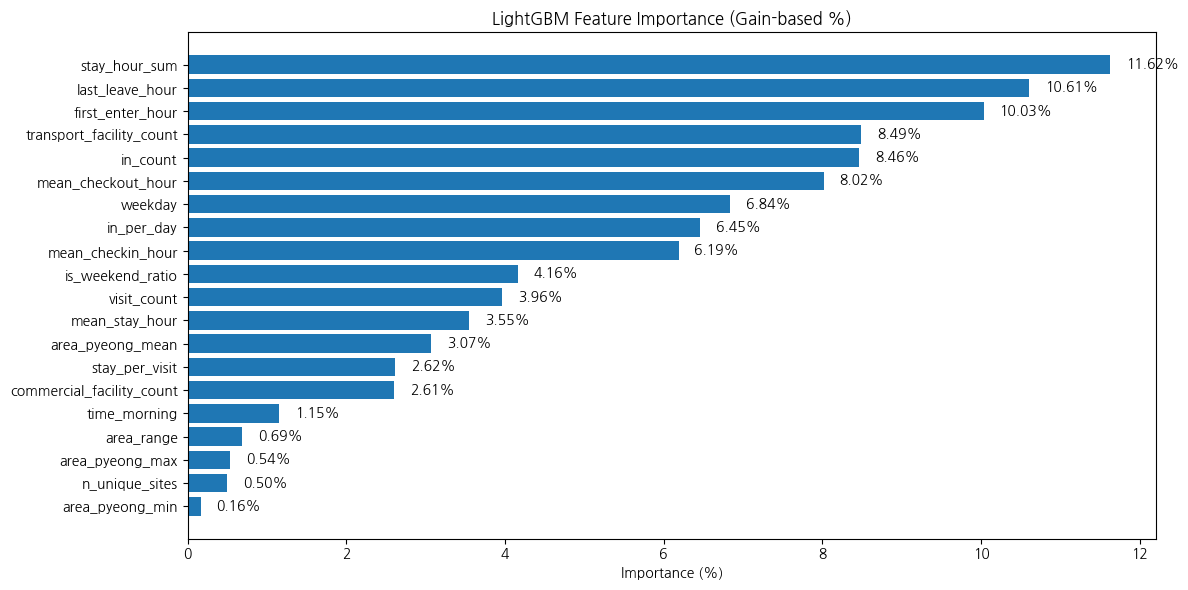

In [ ]:
model = LGBMClassifier(random_state=123)
model.fit(X_train, y_train)

# 2. Feature Importance (gain 기준)
importance_dict = model.booster_.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_dict
})

# 3. 퍼센트로 변환
importance_df['importance_pct'] = 100 * importance_df['importance'] / importance_df['importance'].sum()
importance_df = importance_df.sort_values(by='importance_pct', ascending=False).head(20)

# 4. 시각화
plt.figure(figsize=(12, 6))
bars = plt.barh(importance_df['feature'], importance_df['importance_pct'])

plt.gca().invert_yaxis()
plt.xlabel('Importance (%)')
plt.title('LightGBM Feature Importance (Gain-based %)')

# 수치 레이블 추가
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.2, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%", va='center')

plt.tight_layout()
plt.show()

In [ ]:
# 상권·교통 관련 컬럼 리스트 ---
infra_cols = ['transport_facility_count', 'commercial_facility_count']

full_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_dict
})
full_importance_df['importance_pct'] = (
    100 * full_importance_df['importance'] / full_importance_df['importance'].sum()
)

# --- 인프라 vs 나머지 비교 ---
infra_pct = full_importance_df.query("feature in @infra_cols")['importance_pct'].sum()
user_pct  = 100 - infra_pct   # 나머지 전부

print(f"상권·교통 피처 중요도 합계  : {infra_pct:.2f}%")
print(f"나머지 유저 이용 피처 합계 : {user_pct:.2f}%")


상권·교통 피처 중요도 합계  : 11.09%
나머지 유저 이용 피처 합계 : 88.91%


In [ ]:
#  데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

#  LightGBM 파라미터 (Recall 중심)
lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.035,
    min_child_samples=25,
    colsample_bytree=0.8,
    scale_pos_weight=1.5,
    random_state=123
)

# 모델 학습
lgbm.fit(X_train, y_train)

#  예측 & 평가 (custom threshold만 출력)
y_prob = lgbm.predict_proba(X_test)[:, 1]
custom_thresh = 0.70
y_pred_thr = (y_prob >= custom_thresh).astype(int)

print(f"\n[임계값 {custom_thresh} 적용 성능 평가]")
print("Accuracy:", round(accuracy_score(y_test, y_pred_thr), 4))
print("Precision:", round(precision_score(y_test, y_pred_thr, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, y_pred_thr), 4))
print("F1-Score:", round(f1_score(y_test, y_pred_thr), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))


X_vif = X.select_dtypes(include=['int', 'float']).copy()
X_vif_const = sm.add_constant(X_vif)

vif_data = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [
        variance_inflation_factor(X_vif_const.values, i + 1)
        for i in range(X_vif.shape[1])
    ]
}).sort_values(by="VIF", ascending=False)

print("\nVIF 결과:")
print(vif_data)

[LightGBM] [Info] Number of positive: 1699, number of negative: 2677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 4376, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388254 -> initscore=-0.454657
[LightGBM] [Info] Start training from score -0.454657

[임계값 0.7 적용 성능 평가]
Accuracy: 0.6243
Precision: 0.5473
Recall: 0.1906
F1-Score: 0.2827
ROC-AUC: 0.6065


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide




VIF 결과:
                      Feature         VIF
6             area_pyeong_min         inf
17                 area_range         inf
7             area_pyeong_max         inf
5            area_pyeong_mean  279.515303
0           mean_checkin_hour   79.821036
1          mean_checkout_hour   75.697095
3            first_enter_hour   21.303553
4             last_leave_hour   14.521666
15     visited_multiple_sites   13.282535
9                    in_count   12.059093
8              n_unique_sites   12.045680
16                 in_per_day    9.428232
12             stay_per_visit    9.047178
2              mean_stay_hour    9.023506
11              stay_hour_sum    7.400865
18   transport_facility_count    6.299930
19  commercial_facility_count    5.262655
10                visit_count    4.588068
13                    weekday    2.233474
14           is_weekend_ratio    2.223160


추가 분석

In [ ]:
# 예측 확률 추가 (결제 확률)
clustered_df['payment_proba'] = lgbm.predict_proba(X)[:, 1]

# 결제 확률 0.7 이상을 고확률 그룹으로 정하기
high_proba_df = clustered_df[clustered_df['payment_proba'] >= 0.70].copy()

In [ ]:
# 평균값 계산
mean_all = clustered_df[X.columns].mean()
mean_high = high_proba_df[X.columns].mean()

# 비교 테이블 생성
comparison = pd.DataFrame({
    '전체 평균': mean_all,
    '고확률 평균': mean_high
})
comparison['차이'] = comparison['고확률 평균'] - comparison['전체 평균']

# 정렬
comparison = comparison.sort_values(by='차이', ascending=False)

# 인원 수 정보 추가
comparison_info = comparison.copy()
comparison_info.loc['사용자 수'] = [
    clustered_df.shape[0],  # 전체 사용자 수
    high_proba_df.shape[0],  # 고확률 사용자 수
    high_proba_df.shape[0] - clustered_df.shape[0]  # 차이
]

comparison_info

,전체 평균,고확률 평균,차이
commercial_facility_count,759.338208,770.678492,11.340284
area_range,2.157221,5.210643,3.053422
area_pyeong_max,111.992687,114.079823,2.087135
in_count,4.749543,5.896896,1.147353
first_enter_hour,5.201097,6.278271,1.077174
mean_checkin_hour,6.461609,7.457871,0.996263
last_leave_hour,10.008227,10.817073,0.808846
mean_checkout_hour,8.007678,8.773836,0.766158
area_pyeong_mean,111.000056,111.660008,0.659951
stay_hour_sum,6.124680,6.688470,0.563790


| 지표                              | 전체 평균  | 고확률 평균 | 차이         | 해석                           |
| ------------------------------- | ------ | ------ | ---------- | ---------------------------- |
| **commercial\_facility\_count** | 759.34 | 811.60 | **+52.27** | 상업시설 밀집 지역에서 결제 확률 ↑         |
| **mean\_checkout\_hour**        | 8.01   | 9.51   | **+1.50**  | 평균보다 늦은 퇴실 시 결제 확률 ↑         |
| **visit\_count**                | 1.44   | 2.04   | **+0.60**  | 방문 횟수가 많을수록 결제 가능성 ↑         |
| **time\_day**                   | 0.077  | 0.283  | **+0.21**  | 낮 시간대 체험 시 결제 확률 ↑           |
| **transport\_facility\_count**  | 9.16   | 9.34   | +0.17      | 대중교통 접근성도 소폭 기여 가능성          |
| **time\_morning**               | 0.483  | 0.507  | +0.02      | 아침 이용률은 전체와 유사               |
| **time\_evening**               | 0.018  | 0.008  | -0.01      | 저녁 시간 이용 비중 낮음               |
| **time\_late\_night**           | 0.422  | 0.202  | **-0.22**  | 심야 방문 고객은 결제율 낮음             |
| **weekday**                     | 2.78   | 2.25   | **-0.53**  | 다양한 요일 방문보다 특정 요일 집중 시 결제 ↑  |
| **in\_per\_day**                | 3.18   | 2.51   | **-0.67**  | 하루 여러 번 방문보다 1회 집중 방문 시 결제 ↑ |
| **stay\_hour\_sum**             | 6.12   | 5.24   | **-0.88**  | 오래 머무는 것보다 '짧고 굵게'가 더 효과적    |
| **area\_pyeong\_mean**          | 111.00 | 108.30 | -2.70      | 넓은 공간 여부는 영향 적음              |
| **is\_weekend\_ratio**          | 21.62  | 14.82  | **-6.80**  | 평일 방문자일수록 결제율 ↑              |
| **사용자 수**                       | 5470   | 381    | -5089      | 전체의 약 7%가 고확률 고객군    |


In [ ]:
high_proba_df['cluster'].value_counts()

,count
cluster,
1,589
0,126
2,92
11,40
12,33
10,22


In [ ]:
# 고확률 유저 필터링
high_proba_df = clustered_df[clustered_df['payment_proba'] >= 0.7].copy()
total_high = len(high_proba_df)  # 고확률 전체 수 저장

# 클러스터별 요약
pivot = high_proba_df.groupby('cluster').agg(
    평균예측확률 = ('payment_proba', 'mean'),
    실제_결제여부 = ('is_payment', 'mean'),
    고확률_유저수 = ('user_id', 'count')
)

# 고확률 내 비중 계산
pivot['고확률내_비중(%)'] = (pivot['고확률_유저수'] / total_high * 100).round(2)

# 퍼센트 포맷
pivot['평균예측확률(%)'] = (pivot['평균예측확률'] * 100).round(2)
pivot['실제_결제여부(%)'] = (pivot['실제_결제여부'] * 100).round(2)

# 정렬 및 컬럼 순서 조정
pivot = pivot[['평균예측확률(%)', '실제_결제여부(%)', '고확률_유저수', '고확률내_비중(%)']]
pivot = pivot.sort_values('고확률내_비중(%)', ascending=False)

display(pivot)

,평균예측확률(%),실제_결제여부(%),고확률_유저수,고확률내_비중(%)
cluster,,,,
1,80.05,100.0,589,65.30
0,81.37,100.0,126,13.97
2,78.70,100.0,92,10.20
11,78.95,0.0,40,4.43
12,75.29,0.0,33,3.66
10,76.75,0.0,22,2.44
